In [26]:
id2label = {0: 'balloon'}

In [27]:
import pytorch_lightning as pl
from transformers import DetrForObjectDetection

class Detr(pl.LightningModule):

     def __init__(self):
         super().__init__()
         # replace COCO classification head with custom head
         self.model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-50",
                                                             num_labels=len(id2label),
                                                             ignore_mismatched_sizes=True)
         # see https://github.com/PyTorchLightning/pytorch-lightning/pull/1896


     def forward(self, pixel_values, pixel_mask):
       outputs = self.model(pixel_values=pixel_values, pixel_mask=pixel_mask)

       return outputs



In [28]:
import torch
import matplotlib.pyplot as plt

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    colors = COLORS * 100
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), colors):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{id2label[cl.item()]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

def visualize_predictions(image, outputs, threshold=0.9):
  # keep only predictions with confidence >= threshold
  probas = outputs.logits.softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > threshold

  # convert predicted boxes from [0; 1] to image scales
  bboxes_scaled = rescale_bboxes(outputs.pred_boxes[0, keep].cpu(), image.size)

  # plot results
  plot_results(image, probas[keep], bboxes_scaled)


In [29]:
from transformers import DetrFeatureExtractor

feature_extractor = DetrFeatureExtractor.from_pretrained("facebook/detr-resnet-50")
model_inf = Detr()
model_inf.load_state_dict(torch.load("./ballon_model.pth"))


Some weights of DetrForObjectDetection were not initialized from the model checkpoint at facebook/detr-resnet-50 and are newly initialized because the shapes did not match:
- class_labels_classifier.weight: found shape torch.Size([92, 256]) in the checkpoint and torch.Size([2, 256]) in the model instantiated
- class_labels_classifier.bias: found shape torch.Size([92]) in the checkpoint and torch.Size([2]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


<All keys matched successfully>

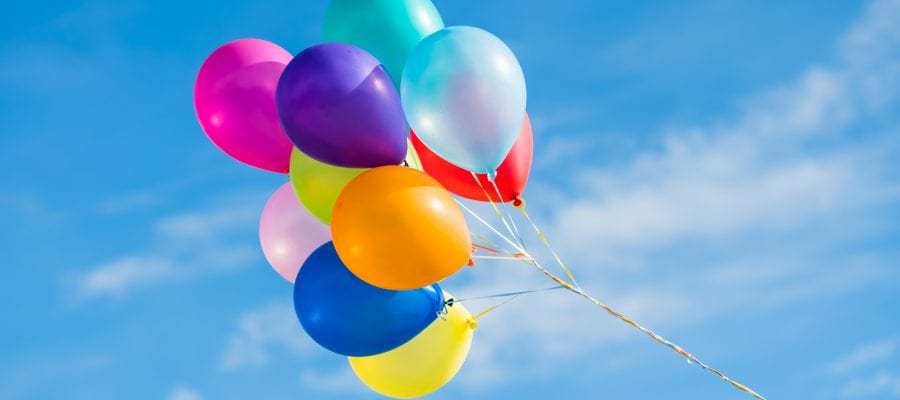

In [30]:
from PIL import Image
import requests

url = 'https://20fd661yccar325znz1e9bdl-wpengine.netdna-ssl.com/wp-content/uploads/2020/08/best-balloons-900x400.jpeg'
im = Image.open(requests.get(url, stream=True).raw)
im

In [31]:
encoding = feature_extractor(im, return_tensors="pt")
encoding.keys()

outputs = model_inf(**encoding)


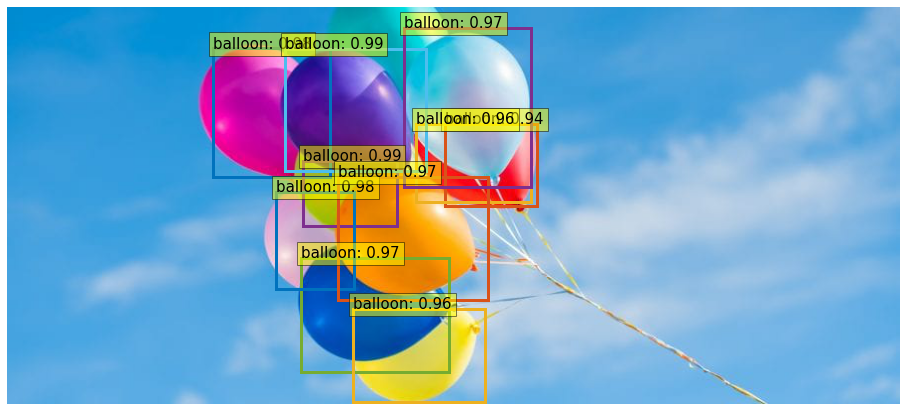

In [32]:
visualize_predictions(im, outputs)